In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
import pandas as pd
import numpy as np
import random
from torchvision import transforms
import matplotlib.pyplot as plt

# Custom Dataset

In [3]:
##################### VARIÁVEIS #####################
IMG_SIZE = 200
N_GRIDS = 5
##################### VARIÁVEIS #####################

In [4]:
class custom_dataset(Dataset):

    def __init__(self, df_path, IMG_SIZE, N_GRIDS):
        self.n_grids = N_GRIDS
        self.img_size = IMG_SIZE
        self.df = pd.read_csv(df_path)
    
    def __getitem__(self, i):
        # img_path,imgw,imgh,xc,yc,w,h,tipo
        anotacao = self.df.loc[i]
        annotations, img_path = self.separar_em_grids(anotacao)
        
        return annotations, img_path
        
    def separar_em_grids(self, anotacao):
        """
        - Pega uma img_pil e retorna uma lista onde cada elemento tem a imagem cortada de acordo com sua respectiva célula.  
        - Retorna [x, y, w, h] do objeto localizado referente ao ponto (topo-esquerda) em valores relativos.  
        - Retorna a posição da célula referente à imagem no geral, [x0, y0] em valores absolutos
        """
        img_path, imgw, imgh, xc, yc, w, h, tipo = anotacao # esses valores vem no formato relativo.
        
        img_pil = Image.open(img_path).resize((self.img_size, self.img_size)) # redimensiona a imagem para o tamanho desejado
        
        xc, yc, w, h = xc*self.img_size, yc*self.img_size, w*self.img_size, h*self.img_size # valores absolutos ao novo tamanho da img

        cco, cso = [], [] # células com objeto, células sem objeto
        cells_size = self.img_size / self.n_grids

        for y in range(self.n_grids):
            for x in range(self.n_grids):
                x0b, y0b, x1b, y1b = x*cells_size, y*cells_size, (x+1)*cells_size, (y+1)*cells_size # valores absolutos
                bbox_celula = [x0b, y0b, x1b, y1b]
                img_croped = img_pil.crop(bbox_celula)
                if ((xc >= x0b and xc <= x1b) and (yc >= y0b and yc <= y1b)):
                    p = 1
                    xc_rel, yc_rel = (xc - x0b)/cells_size, (yc - y0b)/cells_size
                    bbox_objeto = [xc_rel, yc_rel, w/cells_size, h/cells_size]
                    cco.append([img_croped, p, bbox_objeto, bbox_celula, tipo])  # tipo do objeto [0 ou 1]
                else:
                    p = 0
                    xc_rel, yc_rel = 0, 0
                    bbox_objeto = [0, 0, 0, 0]
                    cso.append([img_croped, p, bbox_objeto, bbox_celula, 2]) # 2 porque no caso já existe 0 e 1 de classe. 2 representa vazio
        
        # pegamos os números de imagens que tem objetos
        n_cco = len(cco)  # e colocamos no vetor cco o mesmo número de imagens sem objeto, para que o dataset fique equilibrado
        for _ in range(n_cco):
            cco.append(random.choice(cso))
        
        return cco, img_path

    def __len__(self):
        return len(self.df)

dataset = custom_dataset('annotations.csv', IMG_SIZE=IMG_SIZE, N_GRIDS=N_GRIDS)
annotations, img_path = random.choice(dataset)

# Análise dos dados annotations

[[<PIL.Image.Image image mode=RGB size=40x40 at 0x1C6C72F4D30>, 1, [0.3292682926829265, 0.184668989547038, 0.8536585365853655, 0.9407665505226479], [160.0, 40.0, 200.0, 80.0], 0], [<PIL.Image.Image image mode=RGB size=40x40 at 0x1C6C72F4C70>, 0, [0, 0, 0, 0], [160.0, 160.0, 200.0, 200.0], 2]]


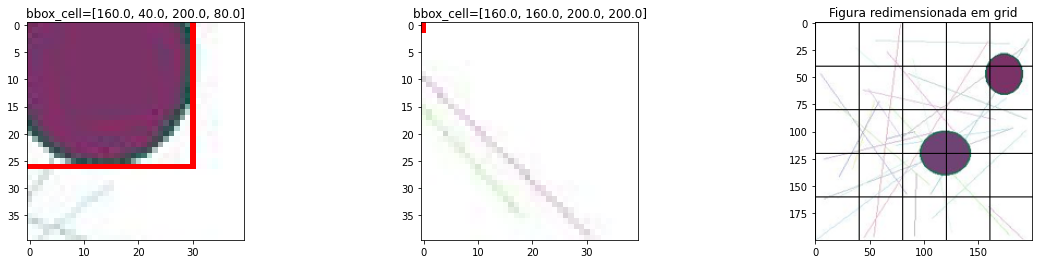

In [14]:
annotations, img_path = random.choice(dataset)
print (annotations)

plt.figure(figsize=(20, 4))
for k, (img_croped, prob_obj, bbox_obj, bbox_cell, tipo_obj) in enumerate(annotations):
    draw = ImageDraw.Draw(img_croped)
    plt.subplot(1, 3, k+1)
    cell_w, cell_h = img_croped.size
    xc, yc, w, h = bbox_obj
    xc, yc, w, h = xc*cell_w, yc*cell_h, w*cell_w, h*cell_h
    x0, y0, x1, y1 = xc-w/2, yc-h/2, xc+w/2, yc+h/2
    draw.rectangle([x0, y0, x1, y1], fill=None, outline='red', width=1)
    plt.title(f'{bbox_cell=}')
    plt.imshow(img_croped)

plt.subplot(1, 3, 3)
final_img = Image.open(img_path).resize((200, 200))
draw = ImageDraw.Draw(final_img)
cell_size = int(200/5)
imgw, imgh = final_img.size
for k in range(5):
    draw.line([0, k*cell_size, imgw, k*cell_size], fill='black', width=1)
    draw.line([k*cell_size, 0, k*cell_size, imgh], fill='black', width=1)

plt.imshow(final_img)
plt.title('Figura redimensionada em grid')
plt.show()

# Análise de um dataloader
## Também com uma função collate_fn

In [16]:
transformer = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

inv_transformer = transforms.Compose([
    transforms.Normalize(mean=(-1., -1., -1), std=(2., 2., 2.)),
    transforms.ToPILImage()
])

def collate_function(batch):
    
    imgs_tensor, bbox_tensor, target_tensor = [], [], []
    
    for annotations, img_path in batch:
        for annotation in annotations:
            img_pil, p_obj, bbox_obj, bbox_cell, target = annotation
            imgs_tensor.append(transformer(img_pil))
            bbox_tensor.append(bbox_obj)
            target_tensor.append(target)
    
    imgs_tensor = torch.stack(imgs_tensor)
    bbox_tensor = torch.tensor(bbox_tensor)
    target_tensor = torch.tensor(target_tensor)

    return imgs_tensor, bbox_tensor, target_tensor

dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_function)
imgs_tensor, bbox_tensor, target_tensor = next(iter(dataloader))
print (f'{imgs_tensor.shape=}, {bbox_tensor.shape=}, {target_tensor}')

imgs_tensor.shape=torch.Size([16, 3, 200, 200]), bbox_tensor.shape=torch.Size([16, 4]), tensor([0, 2, 1, 2, 0, 2, 1, 2, 0, 2, 0, 2, 1, 2, 0, 2])


# Analisando os tensores

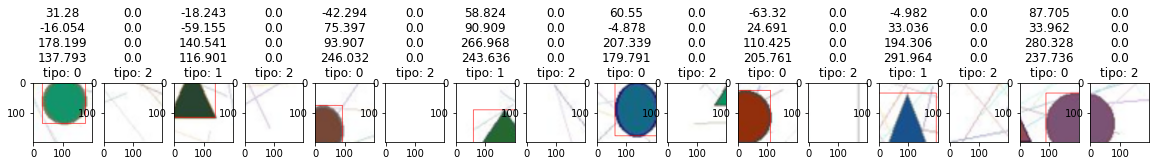

In [18]:
plt.figure(figsize=(20, 4))
n = len(imgs_tensor)
for k, img_tensor in enumerate(imgs_tensor):
    bbox = bbox_tensor[k].detach().cpu().numpy()
    tipo = target_tensor[k].detach().cpu().numpy()
    img_pil = inv_transformer(img_tensor)
    draw = ImageDraw.Draw(img_pil)
    imgw, imgh = img_pil.size
    xc, yc, w, h = bbox
    xc, yc, w, h = xc*imgw, yc*imgh, w*imgw, h*imgh
    x0, y0, x1, y1 = xc-w/2, yc-h/2, xc+w/2, yc+h/2
    draw.rectangle([x0, y0, x1, y1], fill=None, width=2, outline='red')
    plt.subplot(1, n, k+1)
    plt.imshow(img_pil)
    plt.title('\n'.join(str(round(e, 3)) for e in [x0, y0, x1, y1]) + f'\ntipo: {tipo}')

plt.show()